# CS 472 HW 1
Ian McConachie,
CS 472: Humphrey Shi, Steven Walton

February 10, 2023


# Introduction

For this homework we will be using Pytorch as our framework, so let's begin by importing the library.

In [2]:
import torch

For the following exercises, we will primarily be using the CIFAR-10 data set which consists of 60000 32x32 RGB images which have been separed into 10 mutually exclusive, dinstinct classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck). The dataset was assembled as part of the publication *Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.*

Let's import the data into our workspace.

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

cifar_dataset = datasets.CIFAR10(root='./', train=True, download=True, transform=T.ToTensor())
train_data = DataLoader(cifar_dataset, batch_size=1024)

100%|██████████| 170498071/170498071 [00:10<00:00, 16167998.09it/s]


Extracting ./cifar-10-python.tar.gz to ./


The code below takes a look at how each point in the dataset is formatted and then displays a visual representation of the first two pieces of data in the dataset. It is important to develop an intutive understanding of the data we are working with in order to approach the task at hand with machine learning.


Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Shapes: torch.Size([1024, 3, 32, 32]), torch.Size([1024])
Labels: tensor([6, 9, 9,  ..., 1, 4, 6])



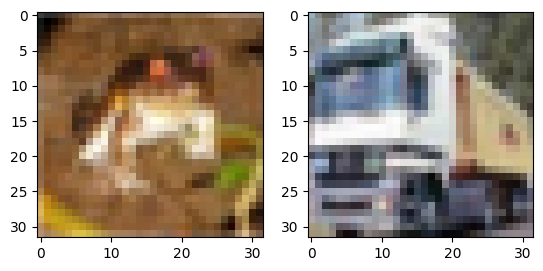

In [4]:
import matplotlib.pyplot as plt

# Code to tell us shape of image data
data = iter(train_data)
single_point = next(data)
print(f"""Type: {type(single_point)}
Length: {len(single_point)}
More Types: {type(single_point[0])}, {type(single_point[1])}
Shapes: {single_point[0].shape}, {single_point[1].shape}
Labels: {single_point[1]}
""")

# Code to display two images
ToPIL = T.ToPILImage() # Converting function
img0 = ToPIL(single_point[0][0]) # ToPIL will transform the Tensor object back to PIL image
img1 = ToPIL(single_point[0][1])
# Plotting
fig, axs = plt.subplots(1,2)
axs[0].imshow(img0)
axs[1].imshow(img1)



A few important measurements which we should note here is that the images have a height and width of 32 and have 3 channels (RGB). This will inform our number of inputs into the neural network we build.

Now let's make a model for this task. We will start with a very basic fully connected model with a three hidden layers. At the end of our network, we'll do a sigmoid function to bound all outputs between \[0,1\] which is what we want for a single label classification task such as the one presented by the CIFAR10 dataset.

# Linear Models

First, let's define some functions that we'll use throughout this exercise.

## Defining Training and Testing Functions

This first function is a general train function which takes in a model and related parameters. Also note that there is a lr_sched option that I added for later experiments with learning rate scheduling which requires different training procedures.

In [5]:
from torch import optim # For optimizing function from torch
from tqdm import tqdm   # For progress bar

# Prefer to use GPU to process, if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, learning_rate, n_epochs, loss_function, optimizer, train_data, lr_sched=False, scheduler=None):

  model.train()
  loss_history = []
  loss = torch.Tensor([0])
  for epoch in tqdm(range(n_epochs), desc=f"Epoch", unit="epoch", disable=False):
    for (data, label) in train_data:
        model.zero_grad()

        # We need to make sure the tensors are on the same device as our model
        data = data.to(device)
        label = label.to(device)
        out = model(data)

        loss = loss_function(out, label)

        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    print(f"Epoch {epoch}: loss: {loss.item()}")
    if (lr_sched):
      scheduler.step()

  return loss_history

This next function graphs the loss history against the number of iterations completed on an xy-plane.

In [6]:
def show_loss_history(lh):
  plt.plot(lh)
  plt.title("Neural Network Loss")
  plt.xlabel("Number of iterations")
  plt.ylabel("Loss")
  plt.show()


Below we have a function that tests the accuracy of a model on test data set for evaluation of the neural networks constructed below. Notice that the default value is set to the test dataset for CIFAR10.

In [7]:
ref_dataset = datasets.CIFAR10(root='./', train=False, download=True, transform=T.ToTensor())
test_data = DataLoader(ref_dataset, batch_size=32)

def test_accuracy(model, test_data=test_data):
  model.eval()
  accuracy = 0
  for (data, label) in test_data:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum()
  print(f"Total accuracy = {accuracy / len(ref_dataset)*100:.2f}%")


Files already downloaded and verified


## Basic Fully Connected Network

Now let's make a model for this task. We will start with a very basic fully connected model with a three hidden layers. The activation function for the neurons in these layers is a rectified linear function--generally considered standard in ML. At the end of our network, we'll do a sigmoid function to bound all outputs between \[0,1\] which is what we want for a classification task such as the one presented by the CIFAR10 dataset.

In [8]:
from torch import nn # importing neural network object

# Defining a basic neural net class that inherits from torch's built in nn class
class BasicNN(nn.Module):

  def __init__(self, n_inputs=3*32*32, n_hidden=2048, n_out=10):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_inputs, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_out),
        nn.Sigmoid()
    )

  def forward(self, x):
    # Batch, channel, height, width
    b, c, h, w = x.shape
    # Flatten the image
    x = x.view(b,-1)
    # Put flattened image through the network
    x = self.net(x)
    return x


Now let's train our network. I chose a learning rate of 0.5, 10 as our number of epochs, stochastic gradient descent as our optimization algorithm, and cross entropy loss as our loss function. These choices were arbitrary, but below we'll experiment with changing them around.

In [9]:
lr_1 = 0.5
model_1 = BasicNN(n_inputs=3*32*32, n_out=10, n_hidden=2048).to(device)
opt_1 = optim.SGD(model_1.parameters(), lr=lr_1)
lf_1 = nn.CrossEntropyLoss()

loss_history = train(model=model_1, learning_rate=lr_1, n_epochs=10, loss_function=lf_1, optimizer=opt_1, train_data=train_data)

Epoch:  10%|█         | 1/10 [01:13<10:57, 73.01s/epoch]

Epoch 0: loss: 2.243288040161133


Epoch:  20%|██        | 2/10 [02:27<09:50, 73.87s/epoch]

Epoch 1: loss: 2.1717841625213623


Epoch:  30%|███       | 3/10 [03:40<08:35, 73.64s/epoch]

Epoch 2: loss: 2.1333677768707275


Epoch:  40%|████      | 4/10 [04:52<07:17, 72.98s/epoch]

Epoch 3: loss: 2.0881688594818115


Epoch:  50%|█████     | 5/10 [06:05<06:04, 72.90s/epoch]

Epoch 4: loss: 2.0710017681121826


Epoch:  60%|██████    | 6/10 [07:18<04:51, 72.93s/epoch]

Epoch 5: loss: 2.0627543926239014


Epoch:  70%|███████   | 7/10 [08:30<03:37, 72.56s/epoch]

Epoch 6: loss: 2.0508131980895996


Epoch:  80%|████████  | 8/10 [09:43<02:25, 72.69s/epoch]

Epoch 7: loss: 2.0472424030303955


Epoch:  90%|█████████ | 9/10 [10:55<01:12, 72.52s/epoch]

Epoch 8: loss: 2.0261943340301514


Epoch: 100%|██████████| 10/10 [12:07<00:00, 72.77s/epoch]

Epoch 9: loss: 2.033109188079834


We can look at the training process visually by grahing the loss over the iterations that occured over each epoch.

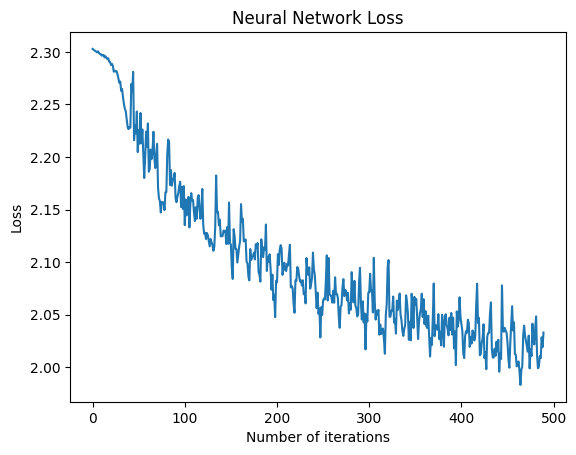

In [10]:
show_loss_history(loss_history)

Now let's look at the accuracy our model acheieves on the validation set which we set aside from the training data at the beginning. Dividing training and testing data is a very important practice in all predictive statistics because it helps to prevent problems like overfitting and helps us to do hyperparameter tweaking.

In [ ]:
test_accuracy(model_1)

Files already downloaded and verified
Total accuracy = 32.86%


The accuracy above will be different every time due to the stochastic processes involved in this process, but I have generally been getting about 30-35% accuracy here. This is better than random selection which has a probability of 10% of being correct.

## Trying Out Different Learning Rates

Let's try tuning some of our hyper parameters. Below I will try two different learning rates: one (lr_2) is 10x smaller than our learning rate of 0.5 which we tried above and the other (lr_3) is roughly 0.5x larger.

Epoch:  10%|█         | 1/10 [00:31<04:39, 31.06s/epoch]

Epoch 0: loss: 2.301030397415161


Epoch:  20%|██        | 2/10 [01:02<04:11, 31.40s/epoch]

Epoch 1: loss: 2.2987918853759766


Epoch:  30%|███       | 3/10 [01:32<03:36, 30.88s/epoch]

Epoch 2: loss: 2.2959508895874023


Epoch:  40%|████      | 4/10 [02:03<03:03, 30.61s/epoch]

Epoch 3: loss: 2.2919771671295166


Epoch:  50%|█████     | 5/10 [02:33<02:31, 30.36s/epoch]

Epoch 4: loss: 2.2860782146453857


Epoch:  60%|██████    | 6/10 [03:05<02:04, 31.02s/epoch]

Epoch 5: loss: 2.277132034301758


Epoch:  70%|███████   | 7/10 [03:35<01:31, 30.59s/epoch]

Epoch 6: loss: 2.263378143310547


Epoch:  80%|████████  | 8/10 [04:04<01:00, 30.36s/epoch]

Epoch 7: loss: 2.243103504180908


Epoch:  90%|█████████ | 9/10 [04:35<00:30, 30.56s/epoch]

Epoch 8: loss: 2.2178070545196533


Epoch: 100%|██████████| 10/10 [05:06<00:00, 30.69s/epoch]

Epoch 9: loss: 2.1946427822113037


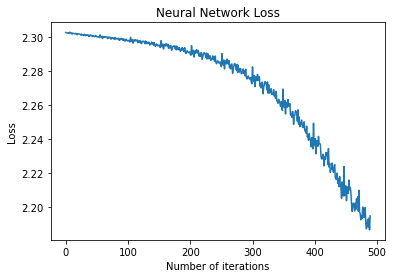

Files already downloaded and verified
Total accuracy = 19.17%


Epoch:  10%|█         | 1/10 [00:30<04:31, 30.17s/epoch]

Epoch 0: loss: 2.225503921508789


Epoch:  20%|██        | 2/10 [01:00<04:00, 30.10s/epoch]

Epoch 1: loss: 2.1653122901916504


Epoch:  30%|███       | 3/10 [01:31<03:33, 30.50s/epoch]

Epoch 2: loss: 2.1338841915130615


Epoch:  40%|████      | 4/10 [02:00<03:01, 30.18s/epoch]

Epoch 3: loss: 2.0808749198913574


Epoch:  50%|█████     | 5/10 [02:31<02:31, 30.23s/epoch]

Epoch 4: loss: 2.065032958984375


Epoch:  60%|██████    | 6/10 [03:01<02:01, 30.35s/epoch]

Epoch 5: loss: 2.0567119121551514


Epoch:  70%|███████   | 7/10 [03:32<01:31, 30.50s/epoch]

Epoch 6: loss: 2.055180788040161


Epoch:  80%|████████  | 8/10 [04:03<01:01, 30.68s/epoch]

Epoch 7: loss: 2.0498783588409424


Epoch:  90%|█████████ | 9/10 [04:33<00:30, 30.36s/epoch]

Epoch 8: loss: 2.0326602458953857


Epoch: 100%|██████████| 10/10 [05:03<00:00, 30.34s/epoch]

Epoch 9: loss: 2.0557360649108887


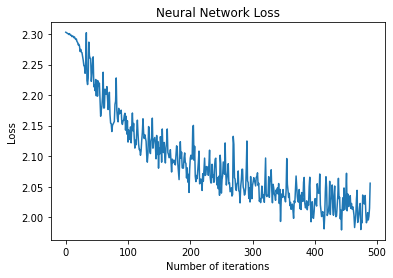

Files already downloaded and verified
Total accuracy = 34.25%


In [ ]:
lr_2 = 0.05
lr_3 = 0.7

# Training and testing model with learning rate of 0.05
model_2 = BasicNN(n_inputs=3*32*32, n_out=10, n_hidden=2048).to(device)
opt_2 = optim.SGD(model_2.parameters(), lr=lr_2)
lf_2 = nn.CrossEntropyLoss()
loss_history2 = train(model=model_2, learning_rate=lr_2, n_epochs=10, loss_function=lf_2, optimizer=opt_2, train_data=train_data)
show_loss_history(loss_history2)
test_accuracy(model_2)

# Training and testing model with learning rate of 0.7
model_3 = BasicNN(n_inputs=3*32*32, n_out=10, n_hidden=2048).to(device)
opt_3 = optim.SGD(model_3.parameters(), lr=lr_3)
lf_3 = nn.CrossEntropyLoss()
loss_history3 = train(model=model_3, learning_rate=lr_3, n_epochs=10, loss_function=lf_3, optimizer=opt_3, train_data=train_data)
show_loss_history(loss_history3)
test_accuracy(model_3)


Our results indicate that the slightly higher learning rate of 0.7 works better for training this particular model while the lower rate of 0.05 performs worse (although there of course is a stochastic component of these results so we cannot guarantee that this will always be the case). The loss functions of these two models' training tells us that the learning rate of 0.05 looks to have been too low for the model to converge within 10 epochs. The learning rate of 0.05 may have actually been more effective than our baseline of 0.5 if we had more computational power or time, but unfortunately I do not have the resources to look into that further.

## Wider Hidden Layers

Now let's try making our network wider--i.e. have more neurons in each of its hidden layers

Epoch:  10%|█         | 1/10 [04:14<38:07, 254.13s/epoch]

Epoch 0: loss: 2.2165026664733887


Epoch:  20%|██        | 2/10 [08:05<32:04, 240.62s/epoch]

Epoch 1: loss: 2.1599619388580322


Epoch:  30%|███       | 3/10 [11:57<27:38, 236.91s/epoch]

Epoch 2: loss: 2.099459648132324


Epoch:  40%|████      | 4/10 [15:43<23:14, 232.36s/epoch]

Epoch 3: loss: 2.080265760421753


Epoch:  50%|█████     | 5/10 [19:29<19:10, 230.00s/epoch]

Epoch 4: loss: 2.0607824325561523


Epoch:  60%|██████    | 6/10 [23:16<15:16, 229.07s/epoch]

Epoch 5: loss: 2.062997817993164


Epoch:  70%|███████   | 7/10 [27:11<11:33, 231.16s/epoch]

Epoch 6: loss: 2.051624298095703


Epoch:  80%|████████  | 8/10 [30:58<07:39, 229.67s/epoch]

Epoch 7: loss: 2.0330708026885986


Epoch:  90%|█████████ | 9/10 [35:05<03:55, 235.17s/epoch]

Epoch 8: loss: 2.024603843688965


Epoch: 100%|██████████| 10/10 [38:53<00:00, 233.32s/epoch]

Epoch 9: loss: 2.0122134685516357


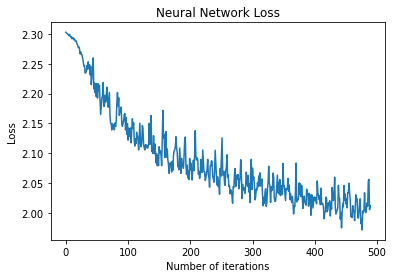

Files already downloaded and verified
Total accuracy = 33.59%


In [ ]:
# Training and testing model with learning rate of 0.05
model_4 = BasicNN(n_inputs=3*32*32, n_out=10, n_hidden=4096).to(device)
opt_4 = optim.SGD(model_4.parameters(), lr=lr_1)
lf_4 = nn.CrossEntropyLoss()
loss_history4 = train(model=model_4, learning_rate=lr_1, n_epochs=10, loss_function=lf_4, optimizer=opt_4, train_data=train_data)
show_loss_history(loss_history4)
test_accuracy(model_4)

This architecture gave us only marginally better results than when we had only 1024 neurons in each layer, but increased the training time significantly. This tells us that the thinner model is preferred because it has a similar level of accuracy with less parameters and a shorter training period.

## Deeper Networks

This time, let's go deeper and have more hidden layers in our network. In the newly defined architecture below you can see I haven't changed many of the other design choices, I simply have more layers.

In [ ]:
class DeepNN(nn.Module):

  def __init__(self, n_inputs=3*32*32, n_hidden=2048, n_out=10):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_inputs, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_out),
        nn.Sigmoid()
    )

  def forward(self, x):
    # Batch, channel, height, width
    b, c, h, w = x.shape
    # Flatten the image
    x = x.view(b,-1)
    # Put flattened image through the network
    x = self.net(x)
    return x

We can train this network by again using our generalized train function.

Epoch:  10%|█         | 1/10 [02:19<20:54, 139.44s/epoch]

Epoch 0: loss: 2.3022830486297607


Epoch:  20%|██        | 2/10 [04:36<18:23, 137.91s/epoch]

Epoch 1: loss: 2.301741361618042


Epoch:  30%|███       | 3/10 [06:52<15:59, 137.09s/epoch]

Epoch 2: loss: 2.3000080585479736


Epoch:  40%|████      | 4/10 [09:12<13:49, 138.30s/epoch]

Epoch 3: loss: 2.2811150550842285


Epoch:  50%|█████     | 5/10 [11:30<11:31, 138.33s/epoch]

Epoch 4: loss: 2.199584484100342


Epoch:  60%|██████    | 6/10 [13:49<09:13, 138.26s/epoch]

Epoch 5: loss: 2.168750762939453


Epoch:  70%|███████   | 7/10 [16:08<06:56, 138.78s/epoch]

Epoch 6: loss: 2.1486988067626953


Epoch:  80%|████████  | 8/10 [18:28<04:38, 139.15s/epoch]

Epoch 7: loss: 2.1433074474334717


Epoch:  90%|█████████ | 9/10 [20:46<02:18, 138.61s/epoch]

Epoch 8: loss: 2.1441967487335205


Epoch: 100%|██████████| 10/10 [23:16<00:00, 139.60s/epoch]

Epoch 9: loss: 2.1387438774108887


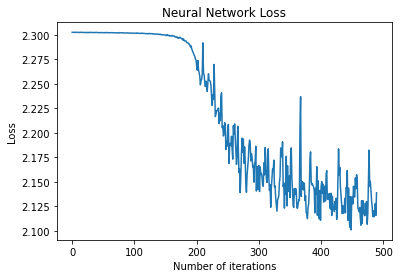

Files already downloaded and verified
Total accuracy = 15.07%


In [ ]:
lr_5 = 0.5
model_5 = DeepNN(n_inputs=3*32*32, n_out=10, n_hidden=2048).to(device)
opt_5 = optim.SGD(model_5.parameters(), lr=lr_5)
lf_5 = nn.CrossEntropyLoss()

loss_history5 = train(model=model_5, learning_rate=lr_5, n_epochs=10, loss_function=lf_5, optimizer=opt_5, train_data=train_data)
show_loss_history(loss_history5)
test_accuracy(model_5)

I was expecting to see better results due to the idea that we can trade width for depth--especially for image classification tasks. However, I am getting a much lower accuracy when compared to just our vanilla linear neural network. My guess is that this has something to do with the parameters being harder to update with many more layers--perhaps we would see better results if we had more epochs.

## Messing Around With SoftMax

The neural network shown below was mostly for my own curiousity rather than structured experimentation. I changed the activation function at the end to a log softmax and changed the loss function to a negative log likelihood function (because cross entropy loss has a negative log likelihood already built into it). I also increased the number of epochs to 20 to see what kind of accuracy I could get and I ended up with the best result I've had yet from the purely linear neural network models.

In [ ]:
class BasicNN_SM(nn.Module):

  def __init__(self, n_inputs=3*32*32, n_hidden=2048, n_out=10):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_inputs, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_out),
        nn.LogSoftmax(dim=1)
    )

  def forward(self, x):
    # Batch, channel, height, width
    b, c, h, w = x.shape
    # Flatten the image
    x = x.view(b,-1)
    # Put flattened image through the network
    x = self.net(x)
    return x


Again we can use our standard training function.

Epoch:   5%|▌         | 1/20 [01:15<23:58, 75.72s/epoch]

Epoch 0: loss: 2.327049493789673


Epoch:  10%|█         | 2/20 [02:31<22:41, 75.61s/epoch]

Epoch 1: loss: 2.216153621673584


Epoch:  15%|█▌        | 3/20 [03:51<22:00, 77.65s/epoch]

Epoch 2: loss: 2.1782093048095703


Epoch:  20%|██        | 4/20 [05:07<20:31, 76.96s/epoch]

Epoch 3: loss: 2.224710464477539


Epoch:  25%|██▌       | 5/20 [06:21<19:00, 76.06s/epoch]

Epoch 4: loss: 2.1832103729248047


Epoch:  30%|███       | 6/20 [07:36<17:36, 75.49s/epoch]

Epoch 5: loss: 2.1046221256256104


Epoch:  35%|███▌      | 7/20 [08:49<16:14, 74.95s/epoch]

Epoch 6: loss: 2.0378754138946533


Epoch:  40%|████      | 8/20 [10:03<14:55, 74.60s/epoch]

Epoch 7: loss: 1.9678401947021484


Epoch:  45%|████▌     | 9/20 [11:16<13:33, 73.99s/epoch]

Epoch 8: loss: 2.0729732513427734


Epoch:  50%|█████     | 10/20 [12:26<12:09, 72.91s/epoch]

Epoch 9: loss: 1.9952272176742554


Epoch:  55%|█████▌    | 11/20 [13:37<10:51, 72.34s/epoch]

Epoch 10: loss: 1.9549990892410278


Epoch:  60%|██████    | 12/20 [14:50<09:38, 72.36s/epoch]

Epoch 11: loss: 1.9738973379135132


Epoch:  65%|██████▌   | 13/20 [16:02<08:25, 72.20s/epoch]

Epoch 12: loss: 1.8908686637878418


Epoch:  70%|███████   | 14/20 [17:14<07:12, 72.13s/epoch]

Epoch 13: loss: 1.8730524778366089


Epoch:  75%|███████▌  | 15/20 [18:26<06:01, 72.31s/epoch]

Epoch 14: loss: 2.102578639984131


Epoch:  80%|████████  | 16/20 [19:39<04:49, 72.49s/epoch]

Epoch 15: loss: 1.9422866106033325


Epoch:  85%|████████▌ | 17/20 [20:52<03:37, 72.43s/epoch]

Epoch 16: loss: 1.8300323486328125


Epoch:  90%|█████████ | 18/20 [22:06<02:25, 72.87s/epoch]

Epoch 17: loss: 1.8928897380828857


Epoch:  95%|█████████▌| 19/20 [23:18<01:12, 72.77s/epoch]

Epoch 18: loss: 1.821984052658081


Epoch: 100%|██████████| 20/20 [24:33<00:00, 73.65s/epoch]

Epoch 19: loss: 1.798168420791626


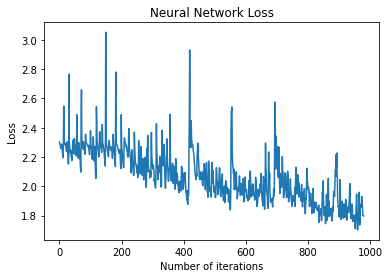

Files already downloaded and verified
Total accuracy = 35.27%


In [ ]:
lr_6 = 0.5
model_6 = BasicNN_SM(n_inputs=3*32*32, n_out=10, n_hidden=2048).to(device)
opt_6 = optim.SGD(model_6.parameters(), lr=lr_6)
lf_6 = nn.NLLLoss()

loss_history6 = train(model=model_6, learning_rate=lr_6, n_epochs=20, loss_function=lf_6, optimizer=opt_6, train_data=train_data)
show_loss_history(loss_history6)
test_accuracy(model_6)

With this network I got slightly better results than with my basic starting linear network. However, this training did have the benefit of twice as many epochs. It seems to me that difference in activation function in the last layer did not have a significant enough benefit to adjust completely.

# Convolutional Network Experiments

## Basic CNN

Below I have defined a very simple convolutional neural network to try out on the CIFAR dataset. Note that the it is divided into two different components: a convolutional part with pooling and 2D convolution layers and a fully connected layer with RELUs and a sigmoid activation function at the end.

In [ ]:
from torch import nn

class SimpleCNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1),
        nn.BatchNorm2d(32)
    )
    self.fc = nn.Sequential(
        nn.Linear(32*32*32, 32),
        nn.ReLU(),
        nn.Linear(32, 10),
        nn.Sigmoid()
    )

  def forward(self, x):
    # Put image through convolutional portion
    x = self.conv(x)
    # Then flatten and put through fc portion
    b, c, h, w = x.shape
    x = x.view(b,-1)
    #print(x)
    x = self.fc(x)
    return x

Here we can train our CNN.

Epoch:  10%|█         | 1/10 [01:56<17:25, 116.21s/epoch]

Epoch 0: loss: 1.9766159057617188


Epoch:  20%|██        | 2/10 [03:46<14:59, 112.47s/epoch]

Epoch 1: loss: 1.9331048727035522


Epoch:  30%|███       | 3/10 [05:47<13:36, 116.64s/epoch]

Epoch 2: loss: 1.9208974838256836


Epoch:  40%|████      | 4/10 [07:45<11:41, 116.92s/epoch]

Epoch 3: loss: 1.900315761566162


Epoch:  50%|█████     | 5/10 [09:36<09:34, 114.96s/epoch]

Epoch 4: loss: 1.8886350393295288


Epoch:  60%|██████    | 6/10 [11:26<07:32, 113.20s/epoch]

Epoch 5: loss: 1.8822104930877686


Epoch:  70%|███████   | 7/10 [13:16<05:37, 112.35s/epoch]

Epoch 6: loss: 1.8632423877716064


Epoch:  80%|████████  | 8/10 [15:16<03:49, 114.77s/epoch]

Epoch 7: loss: 1.8547953367233276


Epoch:  90%|█████████ | 9/10 [17:08<01:53, 113.79s/epoch]

Epoch 8: loss: 1.844470500946045


Epoch: 100%|██████████| 10/10 [18:59<00:00, 113.97s/epoch]

Epoch 9: loss: 1.8392685651779175


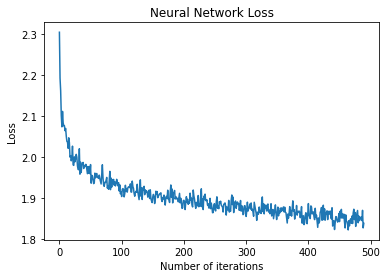

Files already downloaded and verified
Total accuracy = 46.07%


In [ ]:
lr_7 = 0.5
model_7 = SimpleCNN().to(device)
opt_7 = optim.SGD(model_7.parameters(), lr=lr_7)
lf_7 = nn.CrossEntropyLoss()

loss_history7 = train(model=model_7, learning_rate=lr_7, n_epochs=10, loss_function=lf_7, optimizer=opt_7, train_data=train_data)
show_loss_history(loss_history7)
test_accuracy(model_7)

This model gives us much better accuracy than the purely linear NNs which makes sense as CNNs are generally preferred over linear NNs for image classification tasks. The time it took to train this model was also similar to my linear models, which even further improves on the argument for the use of CNNs.

## Learning Rate Scheduling

One machine learning technique that I wanted to try out was learning rate scheduling. I have read a couple of articles that suggested two different types: a step schedule and a cycle schedule. Below I have tried out both. For this experiment I increased the number of epochs so that we can more plainly see the effects of the changing learning rates.

In [ ]:
from torch.optim.lr_scheduler import StepLR, OneCycleLR

Adjusting learning rate of group 0 to 2.0000e+00.


Epoch:   5%|▌         | 1/20 [01:46<33:50, 106.88s/epoch]

Epoch 0: loss: 2.004772424697876
Adjusting learning rate of group 0 to 2.0000e+00.


Epoch:  10%|█         | 2/20 [03:33<32:04, 106.93s/epoch]

Epoch 1: loss: 1.9586981534957886
Adjusting learning rate of group 0 to 2.0000e+00.


Epoch:  15%|█▌        | 3/20 [05:21<30:19, 107.05s/epoch]

Epoch 2: loss: 1.9241831302642822
Adjusting learning rate of group 0 to 2.0000e+00.


Epoch:  20%|██        | 4/20 [07:07<28:28, 106.76s/epoch]

Epoch 3: loss: 1.9028140306472778
Adjusting learning rate of group 0 to 1.0000e+00.


Epoch:  25%|██▌       | 5/20 [08:55<26:48, 107.23s/epoch]

Epoch 4: loss: 1.871439814567566
Adjusting learning rate of group 0 to 1.0000e+00.


Epoch:  30%|███       | 6/20 [10:42<24:58, 107.04s/epoch]

Epoch 5: loss: 1.85989511013031
Adjusting learning rate of group 0 to 1.0000e+00.


Epoch:  35%|███▌      | 7/20 [12:29<23:12, 107.14s/epoch]

Epoch 6: loss: 1.8521901369094849
Adjusting learning rate of group 0 to 1.0000e+00.


Epoch:  40%|████      | 8/20 [14:16<21:24, 107.02s/epoch]

Epoch 7: loss: 1.8525311946868896
Adjusting learning rate of group 0 to 5.0000e-01.


Epoch:  45%|████▌     | 9/20 [16:02<19:36, 106.93s/epoch]

Epoch 8: loss: 1.8361577987670898
Adjusting learning rate of group 0 to 5.0000e-01.


Epoch:  50%|█████     | 10/20 [17:48<17:45, 106.56s/epoch]

Epoch 9: loss: 1.8318614959716797
Adjusting learning rate of group 0 to 5.0000e-01.


Epoch:  55%|█████▌    | 11/20 [19:33<15:53, 105.91s/epoch]

Epoch 10: loss: 1.8300138711929321
Adjusting learning rate of group 0 to 5.0000e-01.


Epoch:  60%|██████    | 12/20 [21:17<14:03, 105.38s/epoch]

Epoch 11: loss: 1.8281916379928589
Adjusting learning rate of group 0 to 2.5000e-01.


Epoch:  65%|██████▌   | 13/20 [23:02<12:17, 105.36s/epoch]

Epoch 12: loss: 1.8153578042984009
Adjusting learning rate of group 0 to 2.5000e-01.


Epoch:  70%|███████   | 14/20 [24:47<10:30, 105.12s/epoch]

Epoch 13: loss: 1.813260793685913
Adjusting learning rate of group 0 to 2.5000e-01.


Epoch:  75%|███████▌  | 15/20 [26:31<08:44, 104.94s/epoch]

Epoch 14: loss: 1.810860276222229
Adjusting learning rate of group 0 to 2.5000e-01.


Epoch:  80%|████████  | 16/20 [28:16<06:59, 104.81s/epoch]

Epoch 15: loss: 1.808234691619873
Adjusting learning rate of group 0 to 1.2500e-01.


Epoch:  85%|████████▌ | 17/20 [30:01<05:14, 104.95s/epoch]

Epoch 16: loss: 1.8035293817520142
Adjusting learning rate of group 0 to 1.2500e-01.


Epoch:  90%|█████████ | 18/20 [31:46<03:29, 104.85s/epoch]

Epoch 17: loss: 1.8020296096801758
Adjusting learning rate of group 0 to 1.2500e-01.


Epoch:  95%|█████████▌| 19/20 [33:31<01:45, 105.08s/epoch]

Epoch 18: loss: 1.8006443977355957
Adjusting learning rate of group 0 to 1.2500e-01.


Epoch: 100%|██████████| 20/20 [35:17<00:00, 105.88s/epoch]

Epoch 19: loss: 1.7990833520889282
Adjusting learning rate of group 0 to 6.2500e-02.


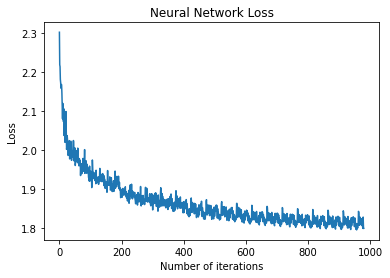

Files already downloaded and verified
Total accuracy = 47.18%
Adjusting learning rate of group 0 to 3.0000e-02.


Epoch:   5%|▌         | 1/20 [01:44<33:11, 104.81s/epoch]

Epoch 0: loss: 1.9979630708694458
Adjusting learning rate of group 0 to 9.8754e-02.


Epoch:  10%|█         | 2/20 [03:30<31:35, 105.30s/epoch]

Epoch 1: loss: 1.9472367763519287
Adjusting learning rate of group 0 to 2.7875e-01.


Epoch:  15%|█▌        | 3/20 [05:15<29:45, 105.05s/epoch]

Epoch 2: loss: 1.935851812362671
Adjusting learning rate of group 0 to 5.0125e-01.


Epoch:  20%|██        | 4/20 [07:00<28:00, 105.01s/epoch]

Epoch 3: loss: 1.9284515380859375
Adjusting learning rate of group 0 to 6.8125e-01.


Epoch:  25%|██▌       | 5/20 [08:46<26:24, 105.66s/epoch]

Epoch 4: loss: 1.921242594718933
Adjusting learning rate of group 0 to 7.5000e-01.


Epoch:  30%|███       | 6/20 [10:35<24:54, 106.75s/epoch]

Epoch 5: loss: 1.956843376159668
Adjusting learning rate of group 0 to 7.4060e-01.


Epoch:  35%|███▌      | 7/20 [12:28<23:33, 108.75s/epoch]

Epoch 6: loss: 1.9398753643035889
Adjusting learning rate of group 0 to 7.1286e-01.


Epoch:  40%|████      | 8/20 [14:25<22:14, 111.17s/epoch]

Epoch 7: loss: 1.927774429321289
Adjusting learning rate of group 0 to 6.6819e-01.


Epoch:  45%|████▌     | 9/20 [16:21<20:41, 112.83s/epoch]

Epoch 8: loss: 1.94500732421875
Adjusting learning rate of group 0 to 6.0881e-01.


Epoch:  50%|█████     | 10/20 [18:21<19:10, 115.08s/epoch]

Epoch 9: loss: 1.949247121810913
Adjusting learning rate of group 0 to 5.3771e-01.


Epoch:  55%|█████▌    | 11/20 [20:22<17:31, 116.86s/epoch]

Epoch 10: loss: 1.9276213645935059
Adjusting learning rate of group 0 to 4.5845e-01.


Epoch:  60%|██████    | 12/20 [22:23<15:45, 118.13s/epoch]

Epoch 11: loss: 1.9344699382781982
Adjusting learning rate of group 0 to 3.7500e-01.


Epoch:  65%|██████▌   | 13/20 [24:25<13:54, 119.18s/epoch]

Epoch 12: loss: 1.9380944967269897
Adjusting learning rate of group 0 to 2.9156e-01.


Epoch:  70%|███████   | 14/20 [26:28<12:03, 120.57s/epoch]

Epoch 13: loss: 1.9275535345077515
Adjusting learning rate of group 0 to 2.1230e-01.


Epoch:  75%|███████▌  | 15/20 [28:29<10:02, 120.55s/epoch]

Epoch 14: loss: 1.9220367670059204
Adjusting learning rate of group 0 to 1.4119e-01.


Epoch:  80%|████████  | 16/20 [30:30<08:02, 120.62s/epoch]

Epoch 15: loss: 1.9198040962219238
Adjusting learning rate of group 0 to 8.1816e-02.


Epoch:  85%|████████▌ | 17/20 [32:30<06:01, 120.58s/epoch]

Epoch 16: loss: 1.9046547412872314
Adjusting learning rate of group 0 to 3.7140e-02.


Epoch:  90%|█████████ | 18/20 [34:31<04:01, 120.67s/epoch]

Epoch 17: loss: 1.8995155096054077
Adjusting learning rate of group 0 to 9.4050e-03.


Epoch:  95%|█████████▌| 19/20 [36:31<02:00, 120.52s/epoch]

Epoch 18: loss: 1.8902336359024048
Adjusting learning rate of group 0 to 3.0000e-06.


Epoch: 100%|██████████| 20/20 [38:31<00:00, 115.60s/epoch]

Epoch 19: loss: 1.8896435499191284
Adjusting learning rate of group 0 to 9.4050e-03.


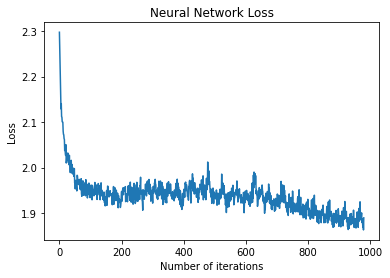

Files already downloaded and verified
Total accuracy = 33.79%


In [ ]:
## Step schedule

lr_8 = 2
model_8 = SimpleCNN().to(device)
opt_8 = optim.SGD(model_8.parameters(), lr=lr_8)
lf_8 = nn.CrossEntropyLoss()

# Halfs the learning rate every 2 epochs
scheduler_8 = StepLR(optimizer=opt_8, step_size=4, gamma=0.5, verbose=True)

loss_history8 = train(model=model_8, learning_rate=lr_8, n_epochs=20, loss_function=lf_8, optimizer=opt_8, train_data=train_data, lr_sched=True, scheduler=scheduler_8)
show_loss_history(loss_history8)
test_accuracy(model_8)

## Cycle schedule
lr_9 = 0.5
model_9 = SimpleCNN().to(device)
opt_9 = optim.SGD(model_9.parameters(), lr=lr_9)
lf_9 = nn.CrossEntropyLoss()

# Halfs the learning rate every 2 epochs
scheduler_9 = OneCycleLR(optimizer=opt_9, max_lr=0.75, anneal_strategy='cos',steps_per_epoch=1, epochs=20, verbose=True)

loss_history9 = train(model=model_9, learning_rate=lr_9, n_epochs=20, loss_function=lf_9, optimizer=opt_9, train_data=train_data, lr_sched=True, scheduler=scheduler_9)
show_loss_history(loss_history9)
test_accuracy(model_9)

The above results will change with every run because of the stochastic nature of these models. However, every time I have ran this script I have seen that the step schedule performs better than the cycle (and better than the CNN without a lr schedule). This makes sense for this situation with a pretty limited number of epochs and unintialized weights.

The cosine cycle schedule gave interesting results, but marginal accuracy. When I ran this I often saw a loss function that was very unique. Specifically as it was seemingly already converged the loss would go up and then decrease again at the end. I am not sure if this is a common feature of cycle learning rate schedules or if it has something to do with this particular implementation.

## Different Optimization Algorithms

For a final little experiment with our basic baseline CNN, I wanted to try out a couple of different optimization algorithms. First, I added momentum to the stochastic gradient descent equation. I find it interesting that SGD in pytorch doesn't automatically add momentum.

Epoch:  10%|█         | 1/10 [01:58<17:46, 118.53s/epoch]

Epoch 0: loss: 2.056964635848999


Epoch:  20%|██        | 2/10 [03:49<15:14, 114.36s/epoch]

Epoch 1: loss: 2.0257821083068848


Epoch:  30%|███       | 3/10 [05:54<13:53, 119.13s/epoch]

Epoch 2: loss: 2.043708324432373


Epoch:  40%|████      | 4/10 [08:03<12:17, 122.84s/epoch]

Epoch 3: loss: 2.01060152053833


Epoch:  50%|█████     | 5/10 [10:18<10:35, 127.13s/epoch]

Epoch 4: loss: 2.0224297046661377


Epoch:  60%|██████    | 6/10 [12:29<08:33, 128.49s/epoch]

Epoch 5: loss: 2.024218797683716


Epoch:  70%|███████   | 7/10 [14:32<06:20, 126.83s/epoch]

Epoch 6: loss: 2.0028042793273926


Epoch:  80%|████████  | 8/10 [16:35<04:10, 125.50s/epoch]

Epoch 7: loss: 2.0080645084381104


Epoch:  90%|█████████ | 9/10 [18:39<02:05, 125.01s/epoch]

Epoch 8: loss: 2.0225768089294434


Epoch: 100%|██████████| 10/10 [20:40<00:00, 124.01s/epoch]

Epoch 9: loss: 2.0049121379852295


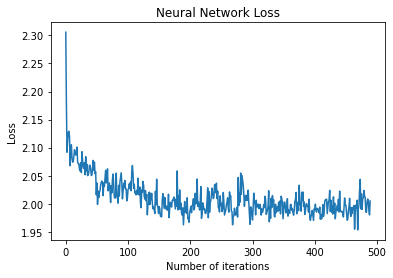

Files already downloaded and verified
Total accuracy = 25.70%


In [ ]:
# Adding momentum to our SGD optimization

lr_10 = 0.5
model_10 = SimpleCNN().to(device)
opt_10 = optim.SGD(model_10.parameters(), lr=lr_10, momentum=0.9)
lf_10 = nn.CrossEntropyLoss()

loss_history10 = train(model=model_10, learning_rate=lr_10, n_epochs=10, loss_function=lf_10, optimizer=opt_10, train_data=train_data)
show_loss_history(loss_history10)
test_accuracy(model_10)

I was surprised that adding momentum ultimately decreased the accuracy of the model. From what I read it seemed like SGD with momentum was generally considered standard practice. I didn't have time to play around with the momentum value or changing up the learning rate, but I am thinking that might've given me some different results.

I also wanted to try out another optimization method that was different than SGD so I poked around a bit and found the Adam optimization algorithm. After playing with the parameters for a while I found that Adam performs very poorly with the learning rate of 0.5 that I have generally been using above. It seems this particular optimizer works best with much lower learning rates which is why I use a rate of 0.001 below.

Epoch:  10%|█         | 1/10 [01:44<15:42, 104.72s/epoch]

Epoch 0: loss: 1.996573805809021


Epoch:  20%|██        | 2/10 [03:29<13:56, 104.50s/epoch]

Epoch 1: loss: 1.9483972787857056


Epoch:  30%|███       | 3/10 [05:12<12:08, 104.06s/epoch]

Epoch 2: loss: 1.9093786478042603


Epoch:  40%|████      | 4/10 [06:57<10:25, 104.26s/epoch]

Epoch 3: loss: 1.8817493915557861


Epoch:  50%|█████     | 5/10 [08:42<08:42, 104.48s/epoch]

Epoch 4: loss: 1.8695486783981323


Epoch:  60%|██████    | 6/10 [10:25<06:56, 104.23s/epoch]

Epoch 5: loss: 1.8619788885116577


Epoch:  70%|███████   | 7/10 [12:09<05:12, 104.14s/epoch]

Epoch 6: loss: 1.85783851146698


Epoch:  80%|████████  | 8/10 [13:53<03:28, 104.05s/epoch]

Epoch 7: loss: 1.8388426303863525


Epoch:  90%|█████████ | 9/10 [15:39<01:44, 104.64s/epoch]

Epoch 8: loss: 1.8373565673828125


Epoch: 100%|██████████| 10/10 [17:39<00:00, 105.96s/epoch]

Epoch 9: loss: 1.8201936483383179


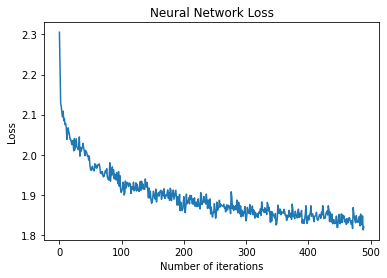

Files already downloaded and verified
Total accuracy = 42.34%


In [ ]:
# Trying out Adam optimization

lr_11 = 0.001
model_11 = SimpleCNN()
opt_11 = optim.Adam(model_11.parameters(), lr=lr_11)
lf_11 = nn.CrossEntropyLoss()

loss_history11 = train(model=model_11, learning_rate=lr_11, n_epochs=10, loss_function=lf_11, optimizer=opt_11, train_data=train_data)
show_loss_history(loss_history11)
test_accuracy(model_11)

The results of this new optimization algorithm were not notably better or worse than SGD. To me it seems like Adam would be good for certain particular situations, but maybe not a general case such as CIFAR10.

## Messing Around CNN

For my final experiment with convolutional neural networks I just wanted to play around with some different activation functions in the architecture. So, instead of RELUs I used ELUs.

In [ ]:
class MyCNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1),
        nn.BatchNorm2d(32)
    )
    self.fc = nn.Sequential(
        nn.Linear(32*32*32, 32),
        nn.ELU(),
        nn.Linear(32, 10),
        nn.Sigmoid()
    )

  def forward(self, x):
    # Put image through convolutional portion
    x = self.conv(x)
    # Then flatten and put through fc portion
    b, c, h, w = x.shape
    x = x.view(b,-1)
    #print(x)
    x = self.fc(x)
    return x

For the training I decided to apply some of the stuff that I played around with above. In particular I used the step schedule for the learning rate--I considered using Adam too but decided to go with what got me results which would be SGD.

Adjusting learning rate of group 0 to 5.0000e-01.


Epoch:  10%|█         | 1/10 [01:12<10:48, 72.02s/epoch]

Epoch 0: loss: 1.974033236503601
Adjusting learning rate of group 0 to 5.0000e-01.


Epoch:  20%|██        | 2/10 [02:20<09:19, 69.93s/epoch]

Epoch 1: loss: 1.9320207834243774
Adjusting learning rate of group 0 to 2.5000e-01.


Epoch:  30%|███       | 3/10 [03:25<07:54, 67.84s/epoch]

Epoch 2: loss: 1.9045599699020386
Adjusting learning rate of group 0 to 2.5000e-01.


Epoch:  40%|████      | 4/10 [04:29<06:36, 66.04s/epoch]

Epoch 3: loss: 1.891772985458374
Adjusting learning rate of group 0 to 1.2500e-01.


Epoch:  50%|█████     | 5/10 [05:32<05:25, 65.04s/epoch]

Epoch 4: loss: 1.8778902292251587
Adjusting learning rate of group 0 to 1.2500e-01.


Epoch:  60%|██████    | 6/10 [06:35<04:17, 64.46s/epoch]

Epoch 5: loss: 1.8730640411376953
Adjusting learning rate of group 0 to 6.2500e-02.


Epoch:  70%|███████   | 7/10 [07:40<03:13, 64.55s/epoch]

Epoch 6: loss: 1.868177890777588
Adjusting learning rate of group 0 to 6.2500e-02.


Epoch:  80%|████████  | 8/10 [08:43<02:08, 64.18s/epoch]

Epoch 7: loss: 1.866034984588623
Adjusting learning rate of group 0 to 3.1250e-02.


Epoch:  90%|█████████ | 9/10 [09:47<01:03, 63.91s/epoch]

Epoch 8: loss: 1.8631861209869385
Adjusting learning rate of group 0 to 3.1250e-02.


Epoch: 100%|██████████| 10/10 [10:51<00:00, 65.14s/epoch]

Epoch 9: loss: 1.862141489982605
Adjusting learning rate of group 0 to 1.5625e-02.


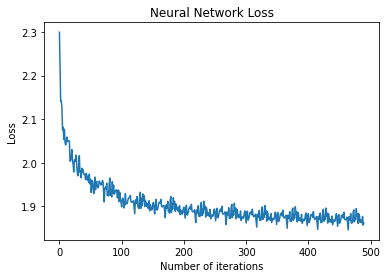

Total accuracy = 45.35%


In [ ]:
lr_12 = 0.5
model_12 = MyCNN().to(device)
opt_12 = optim.SGD(model_12.parameters(), lr=lr_12)
lf_12 = nn.CrossEntropyLoss()
scheduler_12 = StepLR(optimizer=opt_12, step_size=2, gamma=0.5, verbose=True)


loss_history12 = train(model=model_12, learning_rate=lr_12, n_epochs=10, loss_function=lf_12, optimizer=opt_12, train_data=train_data, lr_sched=True, scheduler=scheduler_12)
show_loss_history(loss_history12)
test_accuracy(model_12)

I'm pretty happy with the results of my experimental CNN although I still would like to experiment with pooling layers and other architecture changes in the future.